In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#import dill
import numpy as np
from matplotlib import pyplot as plt


import pandas as pd
from pandas import DataFrame
import more_itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_squared_log_error
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import pipeline

from multiprocessing import Pool
from xgboost import XGBClassifier
import multiprocessing

%matplotlib inline
import seaborn as sns
from IPython.display import display

import warnings
import traceback
warnings.filterwarnings('ignore')
import re
import sys, os
import missingno as msno
import random
sys.path.append(os.getcwd())
import gc

pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
df = pd.read_csv("../data/country_year_features_merged.csv")
df.drop(["index"],axis=1,inplace=True)
df.head()
df.shape

,country,year,clustering_coeff,sorted_tri,indegree_centrality,outdegree_centrality,closeness_centrality,out_closeness_centrality,betweenness_centrality,eigenvector_centrality,eigenvector_centrality_out,nxc,outflow,inflow,share,asylum_outflow,asylum_inflow,iso,population,hdi_value,hdi_rank,fgi_rank,fgi_value,hfi_rank,hfi_value
0,Lebanon,2008,0.377955,1036,0.129534,0.196891,0.504169,0.413960,0.078690,5.843127e-02,0.059869,0.930205,12967.0,50408.0,0.001742,2291.0,510.0,LBN,4111047.0,"0,520833333",69.0,18,95.7,-,-
1,Pakistan,2008,0.304951,1234,0.082902,0.274611,0.381728,0.454270,0.027379,1.545932e-02,0.076161,1.071180,32403.0,1780935.0,0.065275,6254.0,2951.0,PAK,163644603.0,"0,357638889",146.0,9,103.8,133,5.401850448244682
2,Guatemala,2008,0.303571,125,0.025907,0.093264,0.259787,0.259722,0.000297,1.599806e-03,0.006614,0.719619,5934.0,130.0,0.000023,10253.0,5.0,GTM,14006366.0,"0,415277778",128.0,66,80.6,64,7.199325396825397
3,Liberia,2008,0.289320,1956,0.088083,0.404145,0.365325,0.489073,0.012547,1.399127e-02,0.190415,0.267733,75213.0,10224.0,0.000922,2394.0,36.0,LBR,3662993.0,"0,277083333",175.0,34,91.0,-,-
4,Fiji,2008,0.547619,15,0.000000,0.036269,0.000000,0.245762,0.000000,4.630000e-18,0.003602,0.556146,1868.0,NaN,NaN,201.0,6.0,FJI,843340.0,"0,488194444",97.0,87,76.6,48,7.523307205418666


(2011, 25)

### Idea
- We will use Prophet to predict the next year value based on previous year data.
    - we use Prophet because it handles missing data and outliers well
    - https://pypi.org/project/fbprophet/
    - https://anaconda.org/conda-forge/fbprophet
- get features by country level shifted correlation
- We can in the future, use the prediction from prophet as a feature along with gradient and other features in a DNN.
- DNN can be trained in a windowed manner and for all countries at once, so for 2017, We train DNN in 2 instances:
    - 2008-2014,2015
    - 2008-2015,2016
- Finally We plot and show errors for each country as a percentage of actuals (mape)

#### Function Signatures

- Prophet_pred(year)=>prediction for that year for all countries
- DNN Train(year_ranges)=>DNN trained

- Evaluate(Predictions,Actual)=>MAPE,MSE,Plots of APE by country

In [7]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

In [8]:
def mape(y,y_pred):
    y = np.array(y)
    y_pred = np.array(y_pred)
    return 100*np.mean(np.abs(y-y_pred)/(y+1))

def rmsle(y,y_pred):
    y = np.array(y)
    y_pred = np.array(y_pred)
    return np.sqrt(mean_squared_log_error(y,y_pred))

In [9]:
def prophet_country(df,year,country,target="inflow",plot=False):
    actual = df[(df["country"]==country)&(df['year']<=year)][["year",target]]
    actual.rename(columns={"year":"ds",target:"y"},inplace=True)
    actual.reset_index(drop=True,inplace=True)
    actual["ds"] = pd.to_datetime(actual["ds"],format="%Y")
    
    data = df[(df["country"]==country)&(df['year']<year)][["year",target]]
    data.rename(columns={"year":"ds",target:"y"},inplace=True)
    data["ds"] = pd.to_datetime(data["ds"],format="%Y")
    
    future = list(data["ds"].values)+[pd.to_datetime(str(year),format="%Y")]
    future = pd.DataFrame(np.array(future).reshape(-1,1),columns=["ds"])
    # display(future)
    
#     data['floor'] = np.min(data['y'].fillna(0).values)/2
#     future['floor'] = np.max(data['y'].fillna(0).values)/2
    
#     data['cap'] = np.min(data['y'].fillna(0).values)*2
#     future['cap'] = np.max(data['y'].fillna(0).values)*2
    
    m = Prophet(growth='linear',yearly_seasonality=True,n_changepoints=2,
                changepoint_range=0.9,changepoint_prior_scale=0.5)
    # display(data)
    
    take_index = actual['y']>0
    m.fit(data.fillna(0))
    forecast = m.predict(future)
    forecast = forecast.merge(actual,on="ds")
    forecast.loc[forecast['yhat']<=0,"yhat"] = np.min(data['y'].values)/2
    # forecast.loc[forecast['yhat']>=1e9,"yhat"] = np.max(data['y'].values)*2
    forecast[['yhat','y']] = forecast[['yhat','y']].fillna(0)
    # display(forecast)
    forecast['yhat'] = forecast['yhat'].astype(int)
    forecast['y'] = forecast['y'].astype(int)
    
    if plot:
        # display(forecast.tail())
        plt.figure(figsize=(16,8))
        ax = plt.axes()
        last_point = forecast[forecast['ds']==pd.to_datetime(str(year),format="%Y")]
        ax.scatter([pd.to_datetime(str(year),format="%Y")], last_point['y'].values,c='black')
        plt.title("%s :: Yearly Predictions: Overall Error = %s"%(country,mape(forecast[take_index]['y'].values,forecast[take_index]['yhat'].values)))
        fig = m.plot(forecast,ax=ax)
        # add_changepoints_to_plot(fig.gca(), m, forecast)
        plt.show()
        
        # fig2 = m.plot_components(forecast)
    forecast['country'] = country
        
    return forecast[['ds', 'yhat','y','country']]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


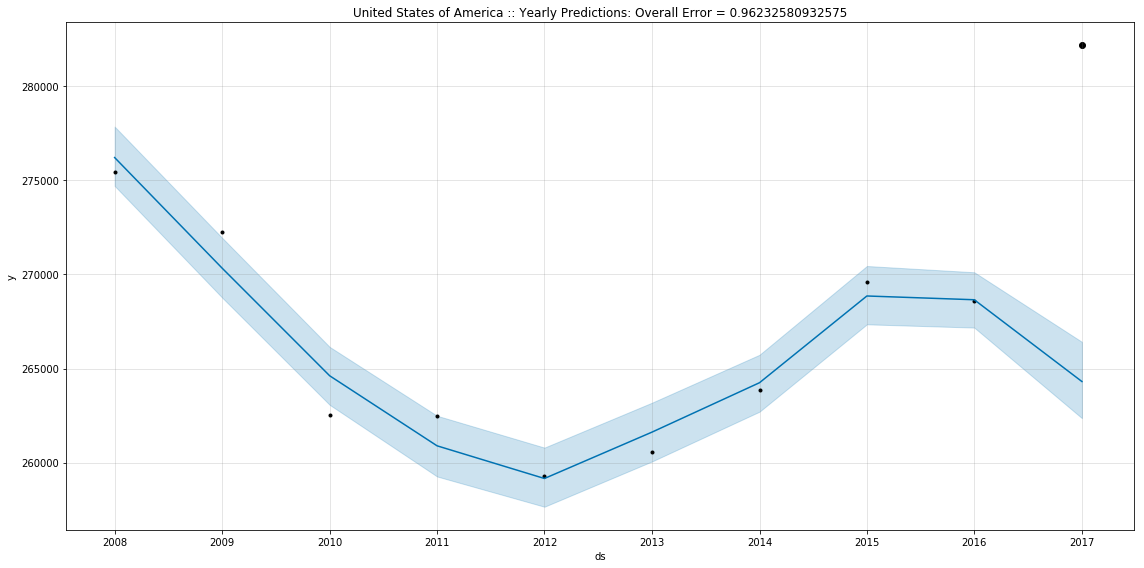

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


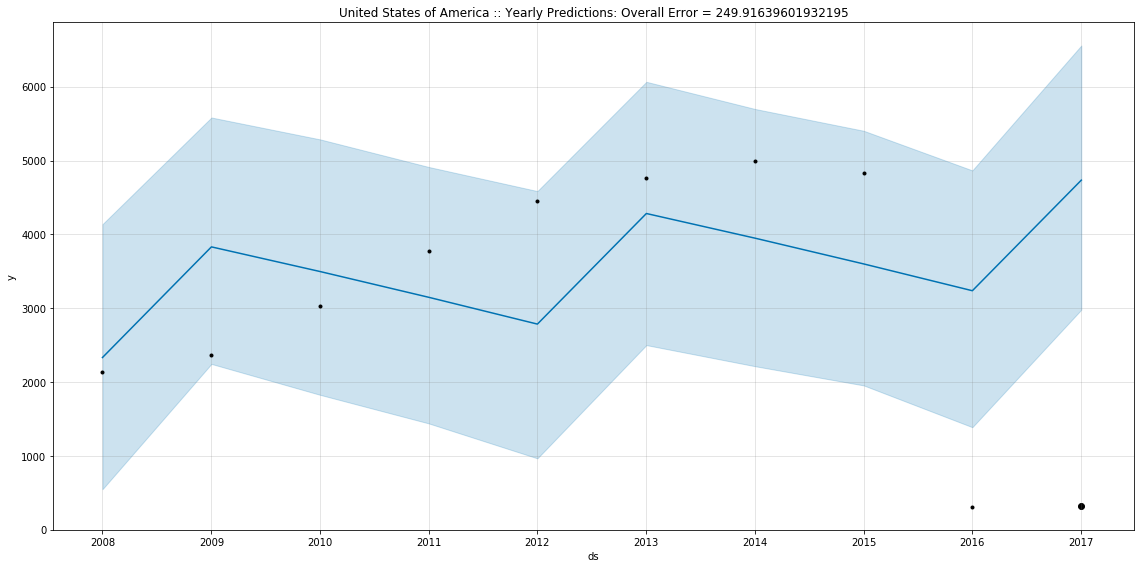

In [10]:
prophet_country(df,2017,'United States of America',"inflow",plot=True);
prophet_country(df,2017,'United States of America',"outflow",plot=True);

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


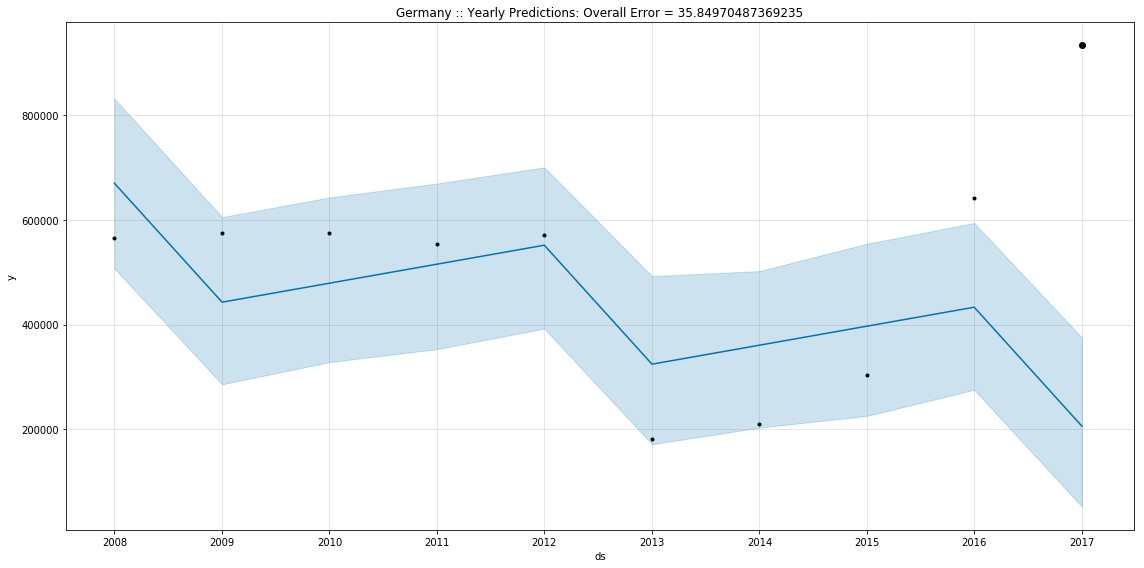

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


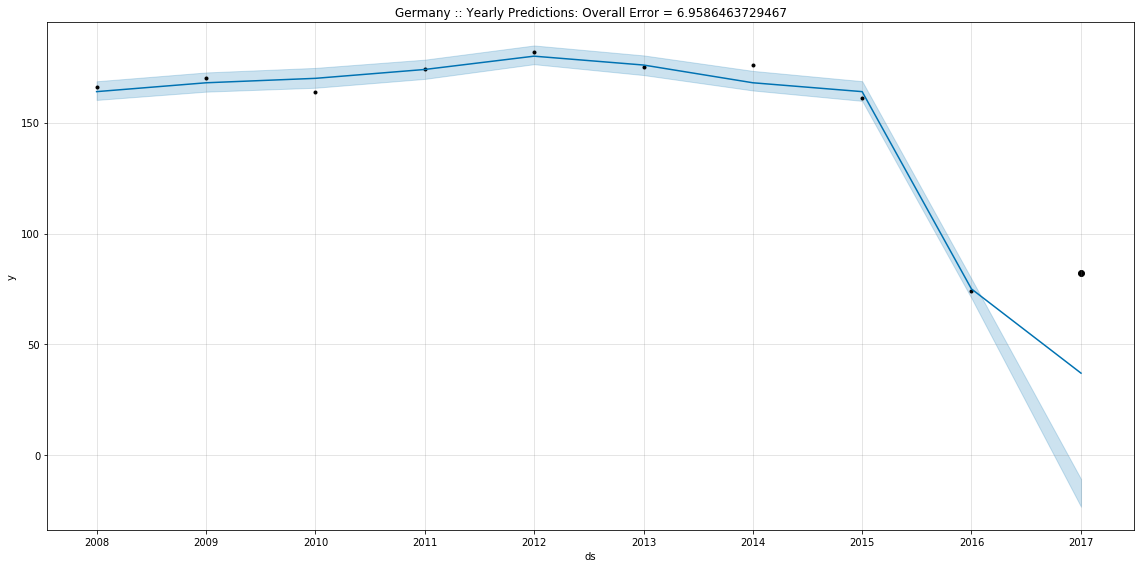

In [11]:
prophet_country(df,2017,"Germany","inflow",plot=True);
prophet_country(df,2017,'Germany',"outflow",plot=True);

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


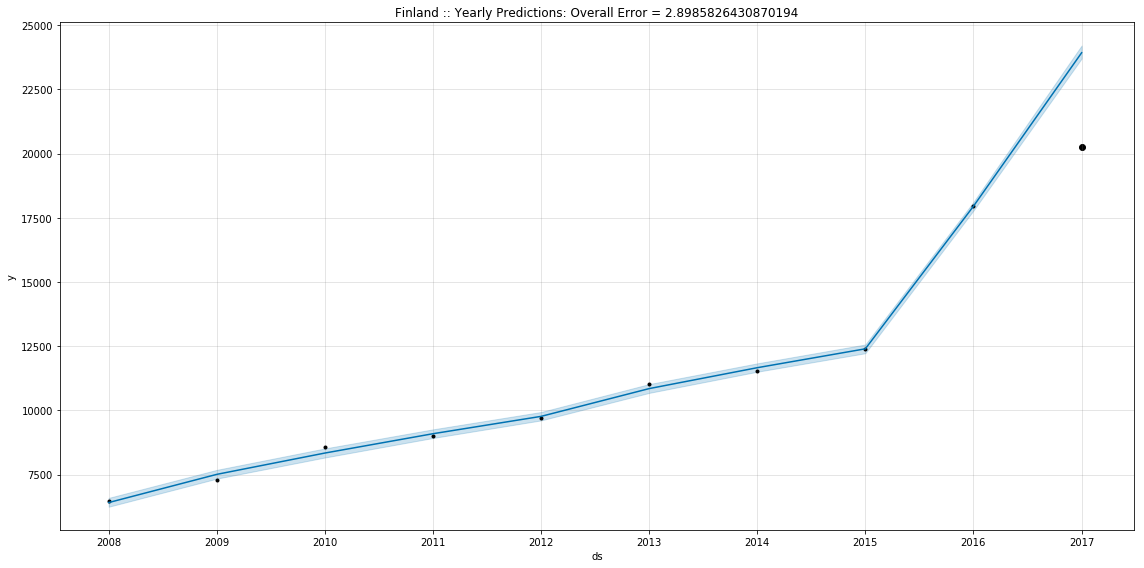

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


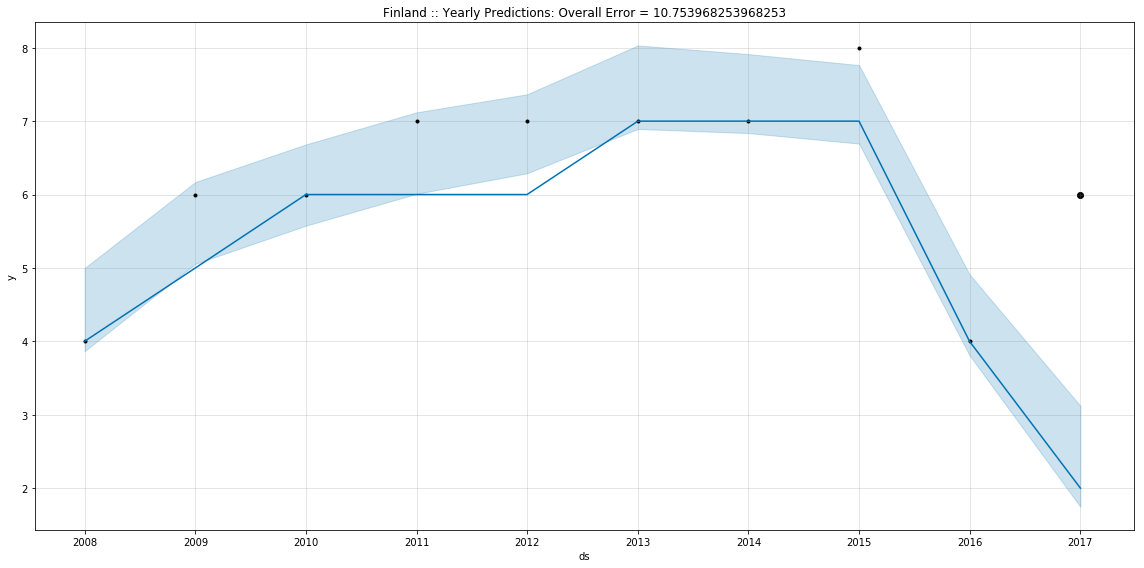

In [12]:
prophet_country(df,2017,"Finland","inflow",plot=True);
prophet_country(df,2017,'Finland',"outflow",plot=True);

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


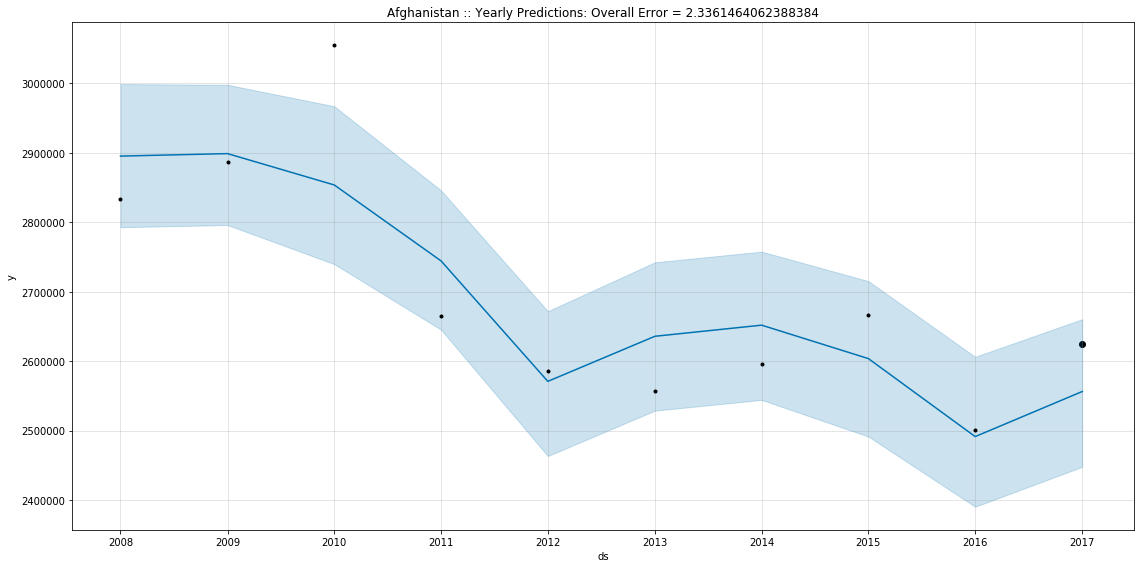

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


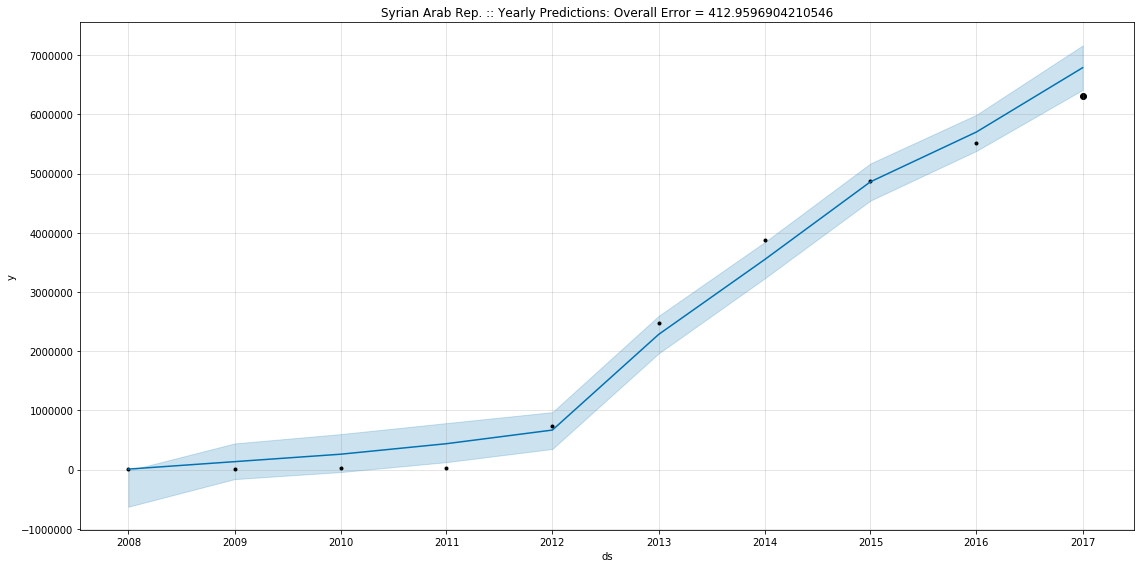

In [13]:
prophet_country(df,2017,'Afghanistan',"outflow",plot=True);
prophet_country(df,2017,'Syrian Arab Rep.',"outflow",plot=True);

In [14]:
def multiple_country_predictions_non_parallel(df,year):
    results = None
    for country in df['country'].unique():
        if df[df['country']==country].shape[0]<=6:
            continue
        print(country)
        res_in = prophet_country(df,year,country,"inflow",plot=False)
        res_in["country"] = country
        res_in.rename(columns={"ds":"year","yhat":"inflow_pred","y":"inflow"},inplace=True)
        
        res_out = prophet_country(df,year,country,"outflow",plot=False)
        res_out["country"] = country
        res_out.rename(columns={"ds":"year","yhat":"outflow_pred","y":"outflow"},inplace=True)
        
        res = res_in.merge(res_out,on=["country","year"])
        if results is None:
            results = res
        else:
            results = pd.concat((results,res),axis=0)
    return results

In [16]:
from joblib import Parallel, delayed
def multiple_country_predictions(df,year):
    country_counts = df.groupby(["country"])[["year"]].count().reset_index()
    country_counts = country_counts[country_counts["year"]>=6]
    countries = country_counts["country"].unique()
    print(len(countries))
    res_ins = Parallel(n_jobs=4,backend="loky")(delayed(lambda country:prophet_country(df,year,country,"inflow",plot=False))(country) for country in countries)
    res_outs = Parallel(n_jobs=4,backend="loky")(delayed(lambda country:prophet_country(df,year,country,"outflow",plot=False))(country) for country in countries)
    res_in = pd.concat(res_ins,axis=0)
    res_out = pd.concat(res_outs,axis=0)
    
    res_in.rename(columns={"ds":"year","yhat":"inflow_pred","y":"inflow"},inplace=True)
    res_out.rename(columns={"ds":"year","yhat":"outflow_pred","y":"outflow"},inplace=True)
    
    results = res_in.merge(res_out,on=["country","year"])
    return results

In [17]:
results = multiple_country_predictions(df,2017)


200


In [18]:
results[results['year']==pd.to_datetime(str(2017),format="%Y")]


,year,inflow_pred,inflow,country,outflow_pred,outflow
9,2017-01-01,215700,75929,Afghanistan,2556292,2624269
19,2017-01-01,171,119,Albania,10529,12179
29,2017-01-01,94336,94265,Algeria,2637,4059
39,2017-01-01,0,0,Andorra,3,4
49,2017-01-01,14252,41135,Angola,4202,8313
59,2017-01-01,6,2,Antigua and Barbuda,101,102
69,2017-01-01,2916,2798,Argentina,64,137
79,2017-01-01,27698,17977,Armenia,8408,10802
89,2017-01-01,44167,45833,Australia,7,16
99,2017-01-01,104677,109637,Austria,3,10


In [19]:
def score_and_plot(results,year):
    results = results.copy()
    results['year'] = results['year'].dt.strftime("%Y").astype(int)
    rdf = results[results['year']==year]
    
    rdf['inflow_percent_error'] = 100*np.abs(rdf['inflow'] - rdf['inflow_pred'])/(rdf['inflow'].fillna(1))
    rdf['outflow_percent_error'] = 100*np.abs(rdf['outflow'] - rdf['outflow_pred'])/(rdf['outflow'].fillna(1))
    
    inflow_rmsle = rmsle(rdf['inflow'],rdf['inflow_pred'])
    outflow_rmsle = rmsle(rdf['outflow'],rdf['outflow_pred'])
    inflow_mape = mape(rdf['inflow'],rdf['inflow_pred'])
    outflow_mape = mape(rdf['outflow'],rdf['outflow_pred'])
    inflow_error_df = rdf[['country','inflow_percent_error']]
    outflow_error_df = rdf[['country','outflow_percent_error']]
    inflows = rdf[['country','inflow','inflow_pred']]
    outflows = rdf[['country','outflow','outflow_pred']]
    errors = rdf[['country','inflow_percent_error','outflow_percent_error']]
    
    inflows = inflows.set_index('country').head(50)
    outflows = outflows.set_index('country').head(50)
    errors = errors.set_index('country').head(50)
    
    inflow_title = "Inflows, RMSE = %.3f, MAPE = %.3f"%(inflow_rmsle,inflow_mape)
    outflow_title = "Outflows, RMSE = %.3f, MAPE = %.3f"%(outflow_rmsle,outflow_mape)
    error_title = "Error Percentages, Inflow MAPE = %.2f, Outflow MAPE = %.2f"%(inflow_mape,outflow_mape)
    
    inflows.plot.bar(rot=90,title=inflow_title,figsize=(20,8),logy=True)
    outflows.plot.bar(rot=90,title=outflow_title,figsize=(20,8),logy=True)
    errors.plot.bar(rot=90, title=error_title,figsize=(20,8))

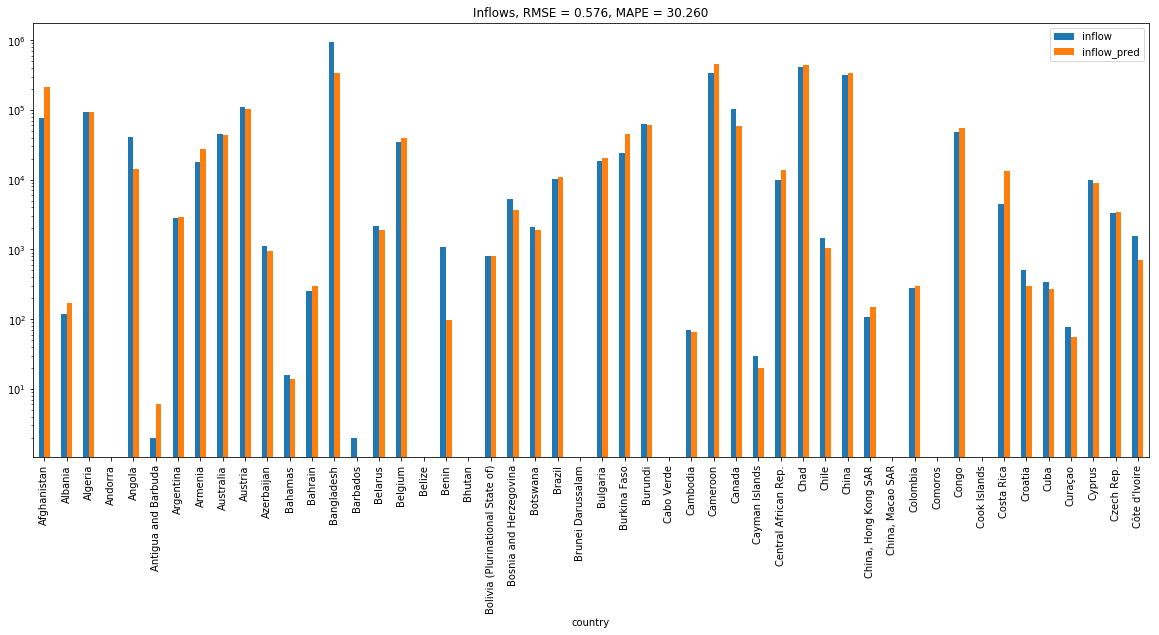

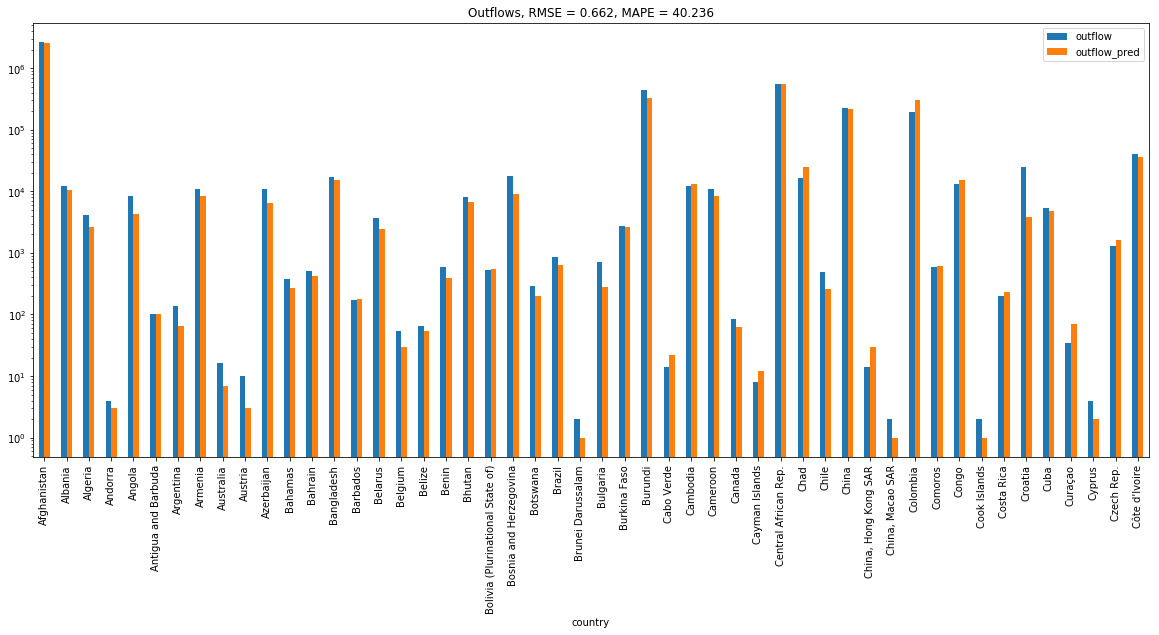

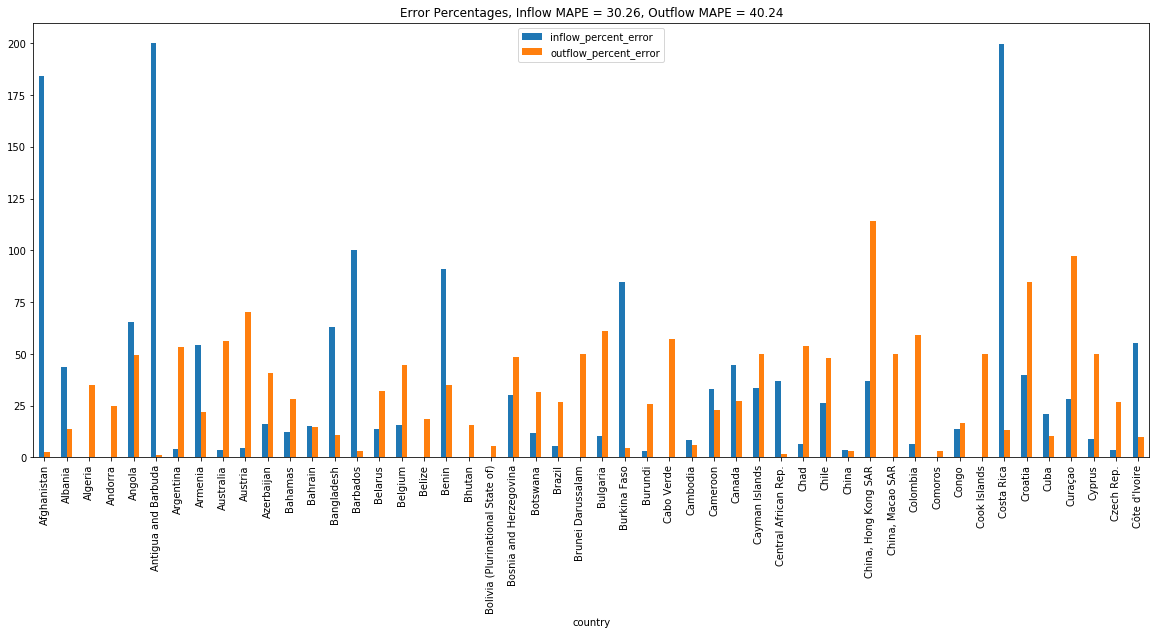

In [20]:
score_and_plot(results,2017)